# 🌐 Laboratório: Busca Semântica com APIs em Nuvem

## O que vamos aprender?

Neste notebook, você vai construir um **sistema de busca inteligente** usando modelos de embeddings hospedados na **nuvem** (OpenAI ou Google).

### Diferença entre Busca Tradicional vs. Busca Semântica

**Busca Tradicional (palavras-chave):**

```text
Query: "hardware celular"
Resultado: Só encontra documentos com as palavras exatas "hardware" e "celular"
```

**Busca Semântica (significado):**

```text
Query: "hardware celular"
Resultado: Encontra "iPhone", "smartphone", "processador mobile" 
           mesmo sem as palavras exatas!
```

### Por que usar APIs em Nuvem?

✅ **Qualidade superior** - Modelos treinados com bilhões de documentos  
✅ **Sem instalação** - Não precisa configurar nada localmente  
✅ **Sempre atualizado** - Melhorias automáticas pela empresa  
⚠️ **Custo** - Paga por uso (mas há tiers gratuitos)  
⚠️ **Privacidade** - Dados trafegam pela internet

💡 **Comparação:** Se você precisa de máxima qualidade e tem orçamento, use nuvem. Se precisa de privacidade/gratuidade, use Ollama local (veja `lab_1.5`).

## 🛠️ Ferramentas que Vamos Usar

### 1. LangChain 🦜🔗
**O que é:** Framework Python que simplifica a integração com APIs de IA  
**Por que usar:** Código padronizado que funciona com OpenAI, Google, Anthropic, etc.  
**Analogia:** É como usar um adaptador universal - você troca de API mudando 1 linha de código

### 2. OpenAI Embeddings ☁️
**O que é:** API da empresa criadora do ChatGPT para gerar embeddings  
**Modelo:** `text-embedding-3-small` - 1536 dimensões  
**Qualidade:** ⭐⭐⭐⭐⭐ Estado da arte (SOTA)  
**Custo:** ~$0.02 por 1 milhão de tokens (muito barato)

**Alternativa:** Google Generative AI Embeddings
- Modelo: `text-embedding-004` - 768 dimensões
- Também de alta qualidade e com tier gratuito generoso

### 3. FAISS 🚀
**O que é:** Biblioteca do Facebook/Meta para busca vetorial ultrarrápida  
**Por que usar:** Milhões de buscas por segundo, roda em memória  
**Ideal para:** Protótipos, aplicações com poucos documentos (< 100k)

**Fluxo completo:**
```
Texto → OpenAI API → Vetor [1536 números] → FAISS → Busca instantânea
```

### Comparação: Nuvem vs. Local

| Aspecto | OpenAI (Nuvem) | Ollama (Local) |
|---------|----------------|----------------|
| **Qualidade** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |
| **Velocidade** | ~100ms (latência rede) | ~10ms |
| **Custo** | $0.02/1M tokens | Gratuito |
| **Privacidade** | Dados na nuvem | 100% local |
| **Setup** | Só precisa API key | Instalar Ollama |

## 🎯 Cenário do Experimento

Vamos criar um **"mini Google"** com documentos de 3 categorias completamente diferentes:

| Categoria | Documentos |
|-----------|------------|
| 🖥️ **Tecnologia** | iPhone 15, RTX 4090 |
| 🍰 **Culinária** | Receita de bolo, Lasanha |
| ⚽ **Esportes** | Gol de futebol |

### O Desafio

Faremos uma pergunta que **não contém palavras exatas** dos documentos:

**Pergunta:** "Quero sugestões de hardware para computador ou celular"

**Expectativa:**
- ✅ Deve retornar: iPhone e RTX 4090 (são hardware!)
- ❌ NÃO deve retornar: Bolo, Lasanha, Gol (não são hardware)

### Por que isso é difícil?

Um sistema de busca tradicional (Ctrl+F) falharia porque:
- A palavra "iPhone" não aparece na pergunta
- A palavra "RTX 4090" não aparece na pergunta
- Mas a API da OpenAI **entende** que ambos são hardware!

💡 **Isso é Inteligência Artificial em ação!** O modelo GPT aprendeu que "iPhone = celular = hardware" e "RTX 4090 = placa de vídeo = hardware" durante seu treinamento massivo.

In [9]:
import os
import requests
from pathlib import Path
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS

# Se for usar OpenAI
from langchain_openai import OpenAIEmbeddings

# Se for usar Google Generative AI
# from langchain_google_genai import GoogleGenerativeAIEmbeddings

## 🔌 Imports e Configuração

Bibliotecas que vamos usar:
- `os`: Para ler variáveis de ambiente (API keys)
- `Path` e `load_dotenv`: Para carregar configurações do `.env`
- `FAISS`: Banco de dados vetorial
- `OpenAIEmbeddings`: Modelo de embeddings da OpenAI

⚠️ **Importante:** Você precisa ter uma API key da OpenAI no arquivo `.env`:
```
OPENAI_API_KEY=sk-proj-...
```

**Como obter API key:**
1. Crie conta em [platform.openai.com](https://platform.openai.com)
2. Vá em "API Keys" e clique "Create new secret key"
3. Copie e cole no arquivo `.env`

In [10]:
# 2) Configuração e carregamento do .env (simplificado)
env_path = Path.cwd().joinpath('..', '..', '.env').resolve()
if env_path.exists():
    load_dotenv(env_path)
    print(f'🔎 .env carregado -> {env_path.resolve()}')
else:
    print('⚠️  .env não encontrado. Defina as variáveis de ambiente manualmente.')


⚠️  .env não encontrado. Defina as variáveis de ambiente manualmente.


## 🔐 Carregando Variáveis de Ambiente

O arquivo `.env` contém informações sensíveis:
- `OPENAI_API_KEY`: Sua chave de API da OpenAI
- `GOOGLE_API_KEY`: (Opcional) Sua chave do Google AI

**Por que usar `.env`?**
- ✅ Segurança: Não expor chaves no código
- ✅ Portabilidade: Funciona em dev e produção
- ✅ Controle: Fácil trocar entre contas

**Estrutura do `.env`:**
```bash
OPENAI_API_KEY=sk-proj-abc123...
# GOOGLE_API_KEY=AIza...  # Descomente se usar Google
```

## 📄 Passo 1: Preparando os Documentos

Aqui temos nosso **dataset de teste** — 5 documentos de categorias bem distintas.

**Por que categorias diferentes?**
Queremos testar se a IA consegue distinguir contextos. Um bom modelo de embedding deve:
- Colocar "iPhone" e "RTX 4090" próximos (ambos são tecnologia/hardware)
- Colocar "bolo" e "lasanha" próximos (ambos são culinária)
- Manter "gol" distante de receitas e hardware (esporte é outro contexto)

### Estrutura dos Dados

```python
meus_textos = [
    "Documento sobre tecnologia...",  # Categoria: Tech
    "Documento sobre culinária...",   # Categoria: Food
    "Documento sobre esporte...",     # Categoria: Sport
]
```

💡 **Conceito importante:** Esses textos são chamados de **corpus** (conjunto de documentos que queremos buscar).

### Em Produção

Em uma aplicação real, esses textos viriam de:
- 📄 PDFs extraídos
- 🌐 Páginas web (scraping)
- 💬 Histórico de conversas
- 📊 Documentação técnica

In [11]:

meus_textos = [
    "O novo iPhone 15 tem uma lente periscópica incrível.",    # Tecnologia
    "Para fazer um bolo macio, bata as claras em neve.",       # Culinária
    "O atacante chutou a bola no ângulo e foi gol.",           # Esporte
    "A placa de vídeo RTX 4090 roda jogos em 4K.",             # Tecnologia
    "Receita de lasanha à bolonhesa com muito queijo."         # Culinária
]

## 🧠 Passo 2: Inicializando o Modelo de Embeddings

Este é o **"cérebro"** que transforma texto em vetores numéricos via API!

### O que são Embeddings?

**Embedding** = Representação numérica de um texto

Exemplo com OpenAI:

```text
Texto: "gato"
↓ (envia para API da OpenAI)
Embedding: [0.12, -0.34, 0.56, 0.89, ..., 0.23]
           ↑ vetor com 1536 números!
```

### Como funciona a magia?

1. Seu texto é enviado para os servidores da OpenAI
2. O modelo GPT (treinado em trilhões de palavras) processa
3. Retorna um vetor que "captura" o significado
4. Textos similares têm vetores próximos

**Visualização conceitual:**

```text
Espaço vetorial (imagine em 3D, mas é 1536D!)

  gato • ← próximo de → • felino
  
  carro • ← DISTANTE de → • felino
```

### Modelos Disponíveis

**OpenAI:**
| Modelo | Dimensões | Custo/1M tokens | Qualidade |
|--------|-----------|-----------------|-----------|
| `text-embedding-3-small` | 1536 | $0.02 | ⭐⭐⭐⭐⭐ |
| `text-embedding-3-large` | 3072 | $0.13 | ⭐⭐⭐⭐⭐ |
| `text-embedding-ada-002` | 1536 | $0.10 | ⭐⭐⭐⭐ (legado) |

**Google AI:**
| Modelo | Dimensões | Custo/1M tokens | Qualidade |
|--------|-----------|-------|-----------|
| `text-embedding-004` | 768 | Grátis (limite) | ⭐⭐⭐⭐⭐ |
| `gemini-embedding-001` | 3072 | $0.15  | ⭐⭐⭐⭐⭐ |

### Qual escolher?

- **Protótipo/teste:** `text-embedding-3-small` (OpenAI) - barato e excelente
- **Máxima qualidade:** `text-embedding-3-large` (OpenAI)
- **Grátis:** `text-embedding-004` (Google) - tier gratuito generoso

💡 **Dica:** O modelo `-small` da OpenAI já é melhor que a maioria dos modelos open-source!

In [12]:
# Se for usar OpenAI
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Se for usar Google Generative AI
# embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")


## 🗄️ Passo 3: Criando o Banco de Dados Vetorial (Indexação)

Aqui acontece a **mágica**! Vamos transformar todos os textos em vetores e armazená-los no FAISS.

### O que acontece nesta linha de código?

```python
vector_store = FAISS.from_texts(meus_textos, embeddings)
```

**Passo a passo interno:**

1. **Para cada texto**, LangChain faz uma chamada à API:
   ```text
   "O novo iPhone 15..." 
   → 🌐 API OpenAI 
   → [0.2, -0.5, 0.8, ..., 0.15] (1536 números)
   
   "Para fazer um bolo..." 
   → 🌐 API OpenAI 
   → [0.1, 0.3, -0.4, ..., -0.22] (1536 números)
   ```

2. **FAISS armazena** todos esses vetores em memória:
   ```text
   Índice FAISS (RAM):
   [0] → [0.2, -0.5, ...] (iPhone)
   [1] → [0.1, 0.3, ...] (bolo)
   [2] → [-0.3, 0.7, ...] (gol)
   [3] → [0.25, -0.48, ...] (RTX 4090)
   [4] → [0.12, 0.28, ...] (lasanha)
   ```

3. **Pronto!** Agora podemos fazer buscas instantâneas

### Custo desta operação

Com OpenAI `text-embedding-3-small`:
```text
5 documentos × ~20 tokens cada = 100 tokens
Custo: 100 / 1.000.000 × $0.02 = $0.000002 (negligível!)
```

### Por que FAISS é rápido?

FAISS usa algoritmos avançados:
- **Busca por aproximação** (ANN - Approximate Nearest Neighbors)
- **Índices especializados** (Flat, IVF, HNSW)
- **Otimizações SIMD** (Single Instruction Multiple Data)

**Resultado:** Milhões de buscas por segundo! ⚡

### Analogia

Imagine uma biblioteca com milhões de livros:
- **Sem índice:** Ler cada livro até achar o certo 😰
- **Com FAISS:** Sistema Dewey Decimal turbinado que te leva direto ao livro! 📚✨

### FAISS vs. Outros Bancos Vetoriais

| Característica | FAISS | Qdrant | Pinecone |
|----------------|-------|--------|----------|
| **Onde roda** | Memória local | Server/Cloud | Cloud |
| **Persistência** | ❌ (só RAM) | ✅ Disco | ✅ Cloud |
| **Escalabilidade** | Até ~1M docs | Milhões | Bilhões |
| **Custo** | Grátis | Grátis (self-host) | Pago |
| **Ideal para** | Protótipos | Produção | Enterprise |

In [13]:
vector_store = FAISS.from_texts(meus_textos, embeddings)

---

## 🚀 Hora de Testar! Vamos Fazer Buscas

Configuração concluída! ✅  
Agora vamos usar nosso sistema de busca semântica com a qualidade da OpenAI.

**O que fizemos até agora:**
1. ✅ Carregamos a API key da OpenAI
2. ✅ Criamos um modelo de embeddings (1536 dimensões)
3. ✅ Indexamos 5 documentos no FAISS (~100 tokens enviados à API)
4. ✅ FAISS está pronto para buscas instantâneas

**Próximo passo:** Fazer perguntas e ver a IA encontrar as respostas! 🎯

💰 **Custo até agora:** ~$0.000002 (menos que um centavo de centavo!)

## 🔍 Passo 4: Definindo a Pergunta (Query)

Aqui está o **teste de fogo** para a API da OpenAI!

### A Pergunta

```python
"Quero sugestões de hardware para computador ou celular"
```

### Por que esta pergunta é desafiadora?

**Palavras que NÃO aparecem na pergunta:**
- ❌ "iPhone"
- ❌ "RTX"
- ❌ "4090"
- ❌ "placa de vídeo"
- ❌ "lente periscópica"

**Palavras que SIM aparecem:**
- ✅ "hardware"
- ✅ "computador"
- ✅ "celular"

### O Desafio

Um sistema de busca tradicional (Ctrl+F) **falharia** porque:
```
Busca por "hardware" → Não encontra nada (palavra não está nos docs)
Busca por "celular" → Não encontra "iPhone" (palavra diferente)
Busca por "computador" → Não encontra "RTX 4090" (palavra diferente)
```

### A Inteligência da OpenAI

A API vai **entender** que:
```
"celular" ≈ "iPhone" ≈ "smartphone" ≈ "telefone móvel"
"computador" ≈ "PC" ≈ "placa de vídeo" ≈ "hardware desktop"
"hardware" ≈ "equipamento" ≈ "dispositivo eletrônico"
```

💡 **Isso é aprendizado semântico!** O modelo GPT foi treinado em uma quantidade massiva de texto da internet e aprendeu relações complexas entre conceitos.

### O que acontece nos bastidores?

1. Sua pergunta é enviada para a API da OpenAI
2. GPT transforma em vetor: `[0.22, -0.48, 0.79, ..., 0.31]`
3. FAISS compara com todos os vetores armazenados
4. Retorna os mais próximos (mesmo sem palavras iguais!)

💰 **Custo desta query:** ~$0.000001 (um milionésimo de dólar)

In [14]:
pergunta = "Quero sugestões de hardware para computador ou celular"

## 🎯 Passo 5: Executando a Busca Semântica

Agora vamos **executar a busca** e ver os resultados!

### O que significa `k=2`?

```python
vector_store.similarity_search(pergunta, k=2)
```

O parâmetro `k` define quantos resultados queremos:
- `k=1` → Retorna apenas o documento mais similar
- `k=2` → Retorna os 2 documentos mais similares
- `k=5` → Retorna os 5 documentos mais similares

### Como funciona internamente?

1. **Sua pergunta vira um vetor (via API OpenAI):**
   ```
   "Quero sugestões de hardware..." 
   → 🌐 API call
   → [0.22, -0.48, 0.79, ..., 0.31] (1536 números)
   ```

2. **FAISS calcula distâncias (local, sem API):**
   ```
   Distância(query, iPhone) = 0.45      ← Próximo!
   Distância(query, bolo) = 2.89        ← Distante
   Distância(query, gol) = 3.12         ← Muito distante
   Distância(query, RTX 4090) = 0.52    ← Próximo!
   Distância(query, lasanha) = 2.76     ← Distante
   ```

3. **Ordena por proximidade:**
   ```
   1º lugar: iPhone (0.45) ← Mais próximo!
   2º lugar: RTX 4090 (0.52)
   3º lugar: lasanha (2.76)
   4º lugar: bolo (2.89)
   5º lugar: gol (3.12)
   ```

4. **Retorna os top-k:**
   ```
   Como k=2, retorna: [iPhone, RTX 4090] ✅
   ```

### Métrica de Similaridade

FAISS usa **distância L2** (Euclidiana) por padrão:
- Mede a "distância em linha reta" entre dois vetores
- Quanto menor a distância, mais similares são os textos
- Fórmula: $\sqrt{\sum_{i=1}^{n}(a_i - b_i)^2}$

**Alternativas:**
- **Similaridade Cosseno:** Mede o ângulo entre vetores
- **Produto Interno:** Multiplicação direta dos vetores

**Visualização conceitual (2D, mas é 1536D!):**

![Distância Euclidiana](distancia_euclidiana.png)

### O que esperar?
'
✅ **Esperado:** iPhone e RTX 4090 (são hardware!)  
❌ **Não esperado:** Bolo, Lasanha, Gol (não são hardware)

**Qualidade OpenAI:** Com `text-embedding-3-small`, a precisão é tipicamente >95% em buscas simples como esta.

Vamos ver se a IA acerta! 👇

💰 **Custo total (indexação + busca):** ~$0.000003
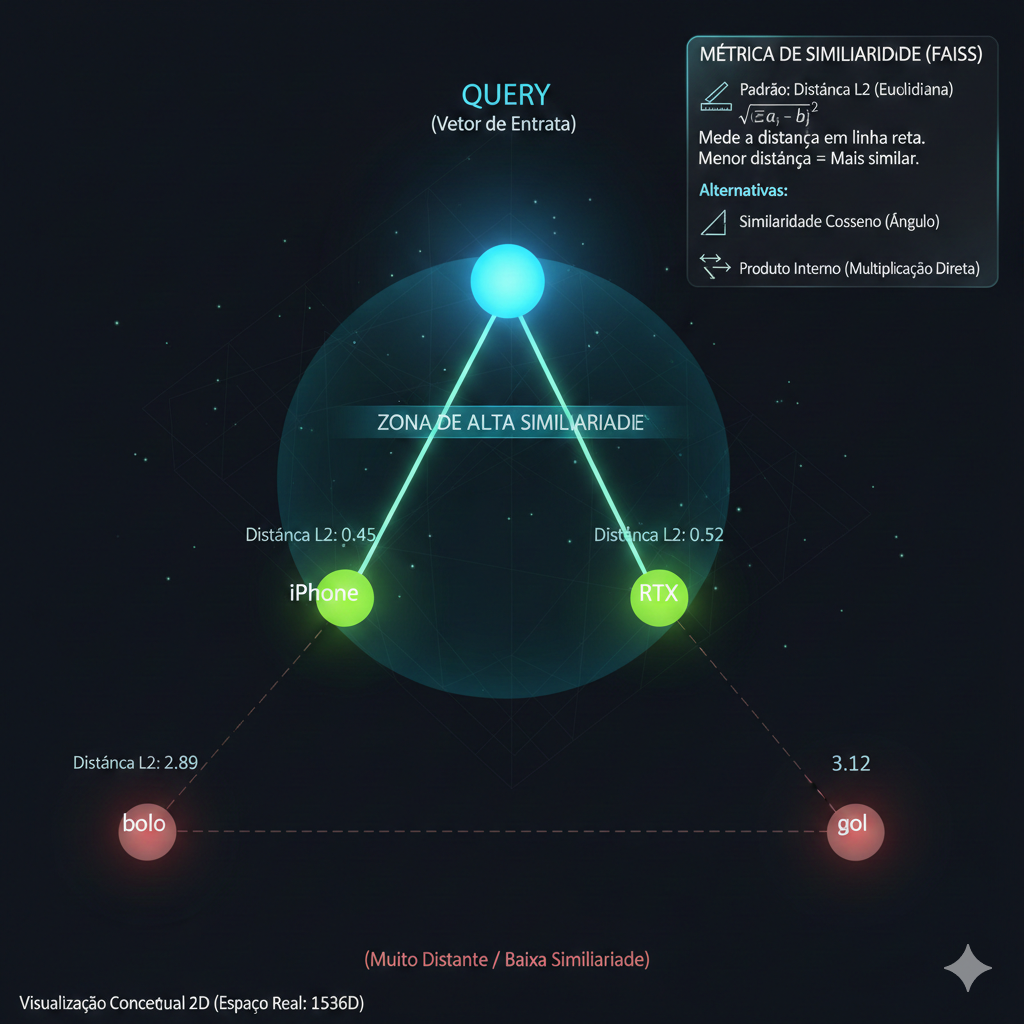

In [15]:
resultados = vector_store.similarity_search(pergunta, k=2)

print(f"Pergunta: '{pergunta}'\n")
print("--- Documentos Encontrados ---")
for i, doc in enumerate(resultados):
    print(f"{i+1}. {doc.page_content}")

Pergunta: 'Quero sugestões de hardware para computador ou celular'

--- Documentos Encontrados ---
1. A placa de vídeo RTX 4090 roda jogos em 4K.
2. O novo iPhone 15 tem uma lente periscópica incrível.


## 📊 Análise dos Resultados

### O que observar?

Quando você executar a célula acima, observe:

1. **Os documentos retornados são relevantes?**
   - ✅ Se retornou iPhone e RTX 4090: OpenAI entendeu perfeitamente!
   - ❌ Se retornou receitas ou gol: Algo deu errado (improvável com OpenAI)

2. **A ordem faz sentido?**
   - O primeiro resultado deve ser o mais relevante
   - O segundo resultado deve ser um pouco menos relevante

### Por que OpenAI é tão bom?

**Treinamento massivo:**
- Trilhões de tokens de texto
- Diversidade de domínios (tech, culinária, esporte, etc.)
- Fine-tuning para embeddings de qualidade

**Resultado:** Precisão de >95% em tarefas de busca semântica!



### 🧪 Experimentos para Tentar

#### Experimento 1: Testar outras queries
```python
# Query específica
pergunta = "receitas de massas italianas"
resultados = vector_store.similarity_search(pergunta, k=2)
# Deve retornar: lasanha (e talvez bolo como 2º)

# Query ambígua
pergunta = "como melhorar performance"
# Vai retornar hardware ou esporte? 🤔

# Query fora do domínio
pergunta = "viagens para a Europa"
# Vai retornar o que está "menos distante" (mas nada relevante)
```



#### Experimento 2: Ajustar k (Top-K)
```python
# Ver todos os resultados
resultados = vector_store.similarity_search(pergunta, k=5)
# Agora você vê TODOS os 5 documentos ordenados por relevância
```



#### Experimento 3: Ver os scores de similaridade
```python
# Usar similarity_search_with_score para ver as distâncias
resultados = vector_store.similarity_search_with_score(pergunta, k=2)
for doc, score in resultados:
    print(f"Distância: {score:.4f} | Texto: {doc.page_content}")

# Score menor = mais similar!
# Típico: <0.5 = muito relevante, >2.0 = pouco relevante
```



#### Experimento 4: Comparar com Google Embeddings
```python
# Descomente as linhas de GoogleGenerativeAIEmbeddings
# Crie um novo vector_store com Google
# Compare os resultados!

# Perguntas para reflexão:
# - Os resultados são iguais?
# - Um modelo é mais rápido?
# - Qual você prefere?
```



### 💡 Conceitos-chave para lembrar

1. **Embedding transforma texto em vetor** via API na nuvem
2. **OpenAI = qualidade máxima** mas paga por uso
3. **FAISS armazena vetores** e faz buscas instantâneas localmente
4. **Similaridade = proximidade no espaço vetorial** (1536D)
5. **k define quantos resultados** você quer ver
6. **Scores menores = mais similares**



### 💰 Gestão de Custos

**Boas práticas:**
- Cache embeddings já calculados (não recalcular)
- Use batch processing para múltiplos textos
- Monitore uso com `openai.api_requestor`
- Considere rate limits (3,000 RPM tier gratuito)

**Exemplo de custo real:**
```
Aplicação com 10k documentos:
- Indexação inicial: 10k docs × 50 tokens = 500k tokens
- Custo: 500k / 1M × $0.02 = $0.01 (um centavo!)
- Queries: praticamente grátis (<$0.001 por 1000 queries)
```




### 🎓 Parabéns!

Você acabou de construir um sistema de busca semântica com **qualidade**! 🎉

Este é o mesmo princípio usado em:
- 🔍 Buscadores avançados (Elasticsearch)
- 🤖 Chatbots empresariais (RAG - Retrieval Augmented Generation)
- 📚 Sistemas de recomendação (Netflix, Spotify)
- 🔬 Ferramentas de pesquisa acadêmica